In [1]:
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import concatenate, Flatten, Dense, Conv2D,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow import keras
import keras.backend as K
import tensorflow as tf
import pandas as pd
import numpy as np

In [2]:
data_path=r'C:\\Users\\HP\\Desktop\\project\\Code\\Rice leaf disease_1\\Training data 1'

In [3]:
# System libraries
from pathlib import Path
import os.path

image_dir = Path(data_path)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)
image_df.head(5)

,Filepath,Label
0,C:\Users\HP\Desktop\project\Code\Rice leaf dis...,Bacterial Leaf Blight
1,C:\Users\HP\Desktop\project\Code\Rice leaf dis...,Bacterial Leaf Blight
2,C:\Users\HP\Desktop\project\Code\Rice leaf dis...,Bacterial Leaf Blight
3,C:\Users\HP\Desktop\project\Code\Rice leaf dis...,Bacterial Leaf Blight
4,C:\Users\HP\Desktop\project\Code\Rice leaf dis...,Bacterial Leaf Blight


In [4]:
from sklearn.model_selection import train_test_split
training_df,testing_df=train_test_split(image_df,test_size=0.2,shuffle=True,random_state=1)

print('The dimension of training data :',training_df.shape)
print('The dimension of testing data :',testing_df.shape)

The dimension of training data : (3054, 2)
The dimension of testing data : (764, 2)


In [5]:
training_generator=ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
testing_generator=ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True)

training_images=training_generator.flow_from_dataframe(

    dataframe=training_df,
    x_col='Filepath',
    y_col='Label',
    class_mode='categorical',
    target_size=(250, 250),    
    color_mode='rgb',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='training'
    
)


validation_images=training_generator.flow_from_dataframe(


    dataframe=training_df,
    x_col='Filepath',
    y_col='Label',
    class_mode='categorical',
    target_size=(250,250),
    color_mode='rgb',
    batch_size=16,
    shuffle=True,
    seed=42,
    subset='validation'

)


testing_images=testing_generator.flow_from_dataframe(


    dataframe=testing_df,
    x_col='Filepath',
    y_col='Label',
    class_mode='categorical',
    target_size=(250,250),
    color_mode='rgb',
    batch_size=16,
    shuffle=False,
)



Found 2444 validated image filenames belonging to 8 classes.
Found 610 validated image filenames belonging to 8 classes.
Found 764 validated image filenames belonging to 8 classes.


In [6]:
early_stopping=EarlyStopping(monitor='val_loss',patience=5,verbose=1,restore_best_weights=True)

reduce_lr=ReduceLROnPlateau(monitor='val_loss',patience=5,verbose=0,factor=0.1)

model_check_point=ModelCheckpoint(monitor='val_accuracy',filepath='./bestmodel.h5',save_best_only=True,verbose=True)

In [7]:
epochs=20
batch_size=32

nb_train_samples = training_images.samples
nb_validation_samples = validation_images.samples

## VGG16

In [8]:
from tensorflow.keras.applications import VGG16

In [10]:
vgg_base = VGG16(  
    include_top=False,  
    weights='imagenet',  
    input_shape=(250, 250, 3),  
)  
   
vgg_base.trainable = False  
  
set_trainable = False  

for layer in vgg_base.layers:  
    if layer.name == 'block5_conv1':  
        set_trainable = True  
    if set_trainable:  
        layer.trainable = True  
  
vgg_model = Sequential()  
  
vgg_model.add(vgg_base)  
  

vgg_model.add(Flatten())  

vgg_model.add(Dense(200, activation='relu'))  
vgg_model.add(Dropout(0.25))

vgg_model.add(Dense(8, activation='softmax'))  


In [11]:
vgg_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 200)               5017800   
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 1608      
                                                                 
Total params: 19,734,096
Trainable params: 5,019,408
Non-trainable params: 14,714,688
_________________________________________________________________


In [12]:
import time
# Record the start time of training
start_time = time.time()

In [13]:
vgg_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history=vgg_model.fit(
    
    training_images,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=validation_images,
    epochs=epochs,
    batch_size=batch_size,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[early_stopping,reduce_lr,model_check_point]

)

Epoch 1/20
76/76 [==============================] - ETA: 0s - loss: 2.5606 - accuracy: 0.2583
Epoch 1: val_accuracy improved from -inf to 0.31908, saving model to .\bestmodel.h5
76/76 [==============================] - 62s 606ms/step - loss: 2.5606 - accuracy: 0.2583 - val_loss: 1.7531 - val_accuracy: 0.3191 - lr: 0.0010
Epoch 2/20
76/76 [==============================] - ETA: 0s - loss: 1.7942 - accuracy: 0.3391
Epoch 2: val_accuracy improved from 0.31908 to 0.41776, saving model to .\bestmodel.h5
76/76 [==============================] - 37s 482ms/step - loss: 1.7942 - accuracy: 0.3391 - val_loss: 1.6530 - val_accuracy: 0.4178 - lr: 0.0010
Epoch 3/20
76/76 [==============================] - ETA: 0s - loss: 1.7205 - accuracy: 0.3548
Epoch 3: val_accuracy did not improve from 0.41776
76/76 [==============================] - 37s 486ms/step - loss: 1.7205 - accuracy: 0.3548 - val_loss: 1.6381 - val_accuracy: 0.3651 - lr: 0.0010
Epoch 4/20
76/76 [==============================] - ETA: 0s -

In [14]:
# Record the training end time
end_time = time.time()

In [15]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 819.0185539722443 seconds


In [16]:
pd.DataFrame(history.history)

,loss,accuracy,val_loss,val_accuracy,lr
0,2.560554,0.258251,1.753081,0.319079,0.001
1,1.794151,0.339109,1.653044,0.417763,0.001
2,1.720538,0.354785,1.638064,0.365132,0.001
3,1.637825,0.384868,1.518695,0.450658,0.001
4,1.604052,0.398849,1.444079,0.457237,0.001
5,1.501108,0.447195,1.482174,0.463816,0.001
6,1.482492,0.454770,1.439462,0.430921,0.001
7,1.462798,0.452145,1.437718,0.473684,0.001
8,1.471676,0.439967,1.367675,0.493421,0.001
9,1.410806,0.466172,1.299211,0.549342,0.001


In [17]:
history=vgg_model.fit(
    
    training_images,
    steps_per_epoch=nb_train_samples // batch_size,
    validation_data=validation_images,
    epochs=5,
    batch_size=batch_size,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=[early_stopping,reduce_lr,model_check_point]

)

Epoch 1/5
76/76 [==============================] - ETA: 0s - loss: 1.2587 - accuracy: 0.5239
Epoch 1: val_accuracy did not improve from 0.59868
76/76 [==============================] - 35s 461ms/step - loss: 1.2587 - accuracy: 0.5239 - val_loss: 1.2286 - val_accuracy: 0.5691 - lr: 0.0010
Epoch 2/5
76/76 [==============================] - ETA: 0s - loss: 1.2484 - accuracy: 0.5380
Epoch 2: val_accuracy did not improve from 0.59868
76/76 [==============================] - 37s 485ms/step - loss: 1.2484 - accuracy: 0.5380 - val_loss: 1.2668 - val_accuracy: 0.5526 - lr: 0.0010
Epoch 3/5
76/76 [==============================] - ETA: 0s - loss: 1.2607 - accuracy: 0.5362
Epoch 3: val_accuracy did not improve from 0.59868
76/76 [==============================] - 38s 500ms/step - loss: 1.2607 - accuracy: 0.5362 - val_loss: 1.1803 - val_accuracy: 0.5789 - lr: 0.0010
Epoch 4/5
76/76 [==============================] - ETA: 0s - loss: 1.1959 - accuracy: 0.5446
Epoch 4: val_accuracy improved from 0.59

In [19]:
import joblib

joblib.dump(history.history,'history_best_VGG16.pkl')
history_CNN2 = joblib.load('history_best_VGG16.pkl')

In [20]:
def plot_performance(model_name, acc, val_acc, loss, val_loss):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('{} : Loss'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.subplot(1,2,2)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('{} : Accuracy'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='lower right')

  plt.tight_layout()

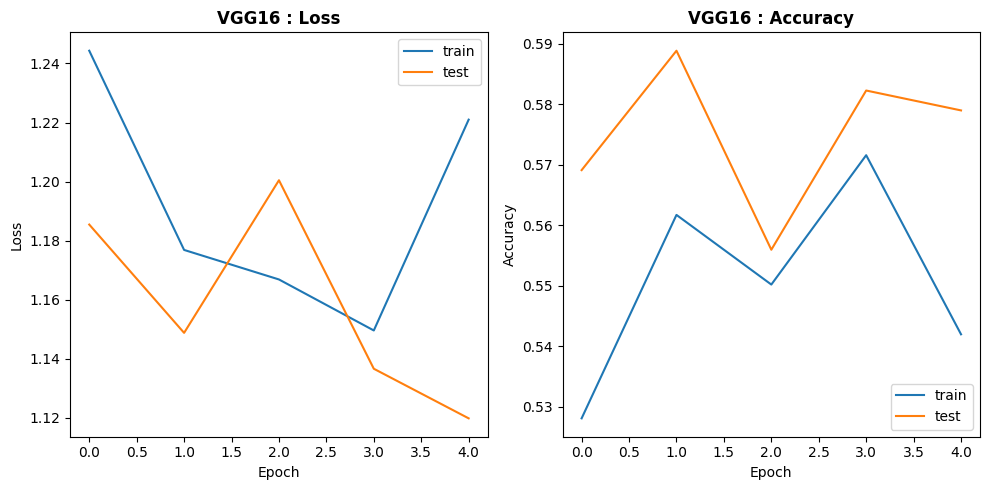

In [21]:
plot_performance(model_name='VGG16',
                acc=history_CNN2['accuracy'], 
                 val_acc=history_CNN2['val_accuracy'],
                 loss=history_CNN2['loss'], 
                 val_loss=history_CNN2['val_loss'])

In [22]:
Evaluation=vgg_model.evaluate(testing_images)


print("Test Accuracy: {:.2f}%".format(Evaluation[1] * 100))
print("Test Loss: {:.5f}".format(Evaluation[0]))


48/48 [==============================] - 17s 348ms/step - loss: 1.0424 - accuracy: 0.6270
Test Accuracy: 62.70%
Test Loss: 1.04243


In [23]:
import itertools

#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

48/48 [==============================] - 17s 348ms/step
Classification Report
                        precision    recall  f1-score   support

 Bacterial Leaf Blight       0.47      0.77      0.58        81
            Brown Spot       0.84      0.55      0.67       107
     Healthy Rice Leaf       0.87      0.73      0.79        73
            Leaf Blast       0.62      0.61      0.61       142
            Leaf scald       0.48      0.50      0.49        94
Narrow Brown Leaf Spot       0.30      0.29      0.29        59
            Rice Hispa       0.76      0.84      0.80        96
         Sheath Blight       0.70      0.63      0.67       112

              accuracy                           0.62       764
             macro avg       0.63      0.61      0.61       764
          weighted avg       0.65      0.62      0.63       764



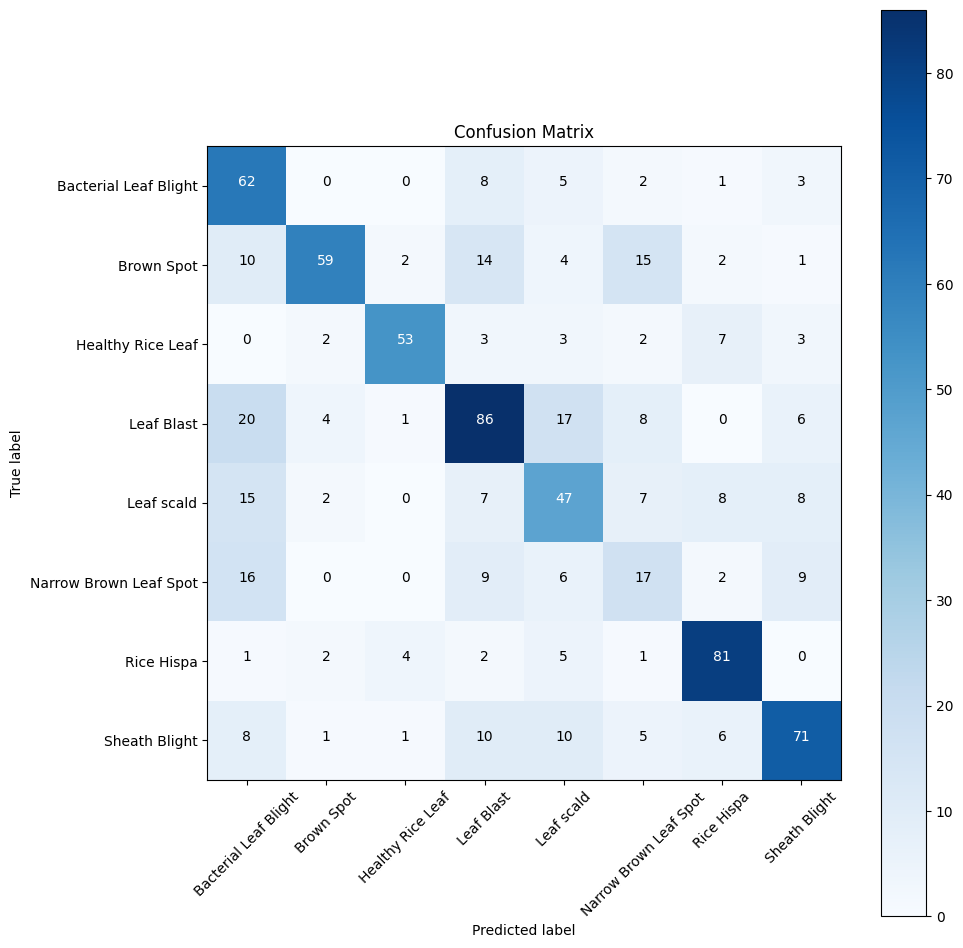

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

#Confution Matrix and Classification Report
Y_pred = vgg_model.predict(testing_images)#, nb_test_samples // BATCH_SIZE, workers=1)
y_pred = np.argmax(Y_pred, axis=1)
classes = list(training_images.class_indices.keys())
target_names = classes

#Confution Matrix
cm = confusion_matrix(testing_images.classes, y_pred)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(testing_images.classes, y_pred, target_names=target_names, zero_division=1))

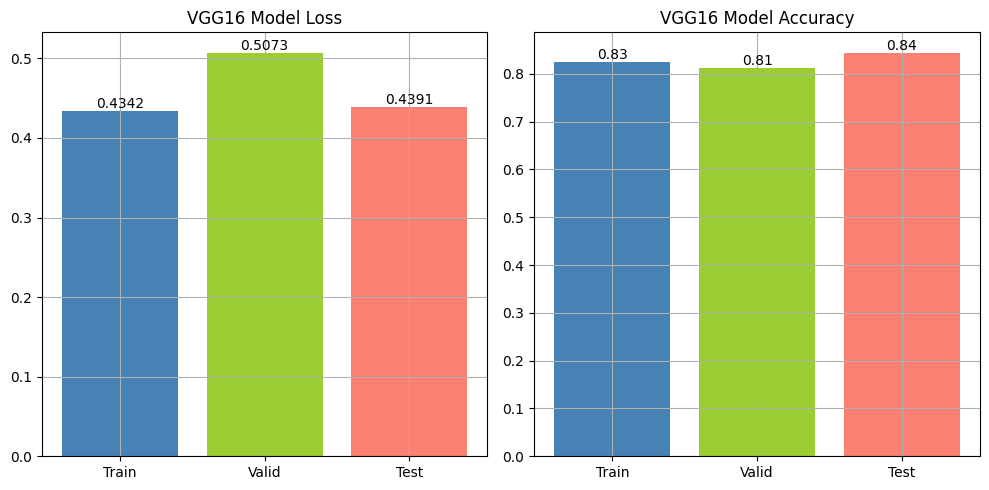

In [2]:
# Visualizing Model Performance
loss_values = [0.434231, 0.5072978734970093, 0.4391366243362427]  
accuracy_values = [0.825850, 0.811904788017273, 0.8446969985961914] 

plt.figure(figsize=(10, 5))  
  
# 第一个子图：模型损失  
plt.subplot(1, 2, 1)  
plt.title("VGG16 Model Loss")  
plt.bar(["Train", "Valid", "Test"], loss_values, color=['steelblue', 'yellowgreen', 'salmon'])  
  
# 为模型损失的每个条形添加数字标签  
for index, value in enumerate(loss_values):  
    plt.text(index, value, f'{value:.4f}', ha='center', va='bottom')  
  
plt.grid()  
  
# 第二个子图：模型准确率  
plt.subplot(1, 2, 2)  
plt.title("VGG16 Model Accuracy")  
plt.bar(["Train", "Valid", "Test"], accuracy_values, color=['steelblue', 'yellowgreen', 'salmon'])  
  
# 为模型准确率的每个条形添加数字标签  
for index, value in enumerate(accuracy_values):  
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')  
  
plt.grid()  
  
# 显示图表  
plt.tight_layout()  # 确保子图之间不会重叠  
plt.show()

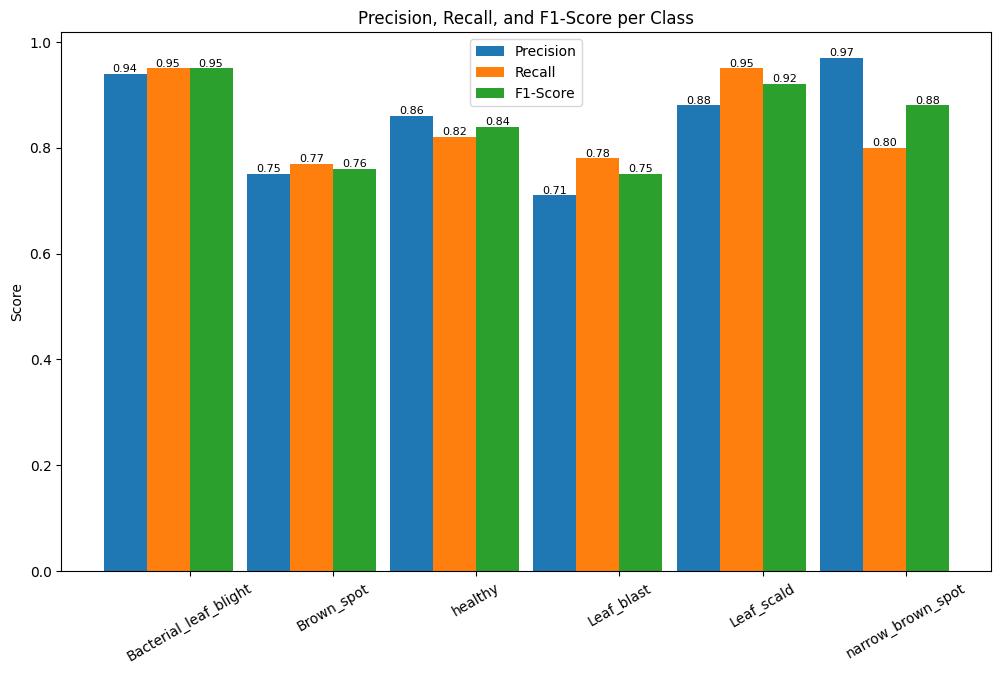

In [35]:
data = [['Bacterial_leaf_blight', 0.94, 0.95, 0.95],  
         ['Brown_spot', 0.75, 0.77, 0.76], 
         ['healthy', 0.86, 0.82, 0.84], 
         ['Leaf_blast', 0.71, 0.78, 0.75],
         ['Leaf_scald', 0.88, 0.95, 0.92],
         ['narrow_brown_spot', 0.97, 0.80, 0.88]]  
  
# 创建DataFrame  
df = pd.DataFrame(data, columns=['Classes', 'precision', 'recall', 'f1-score'])  
  
# 设置图形的宽度和位置  
N = len(df)  
ind = range(N)  
width = 0.3  # 条形图的宽度  
fig, ax = plt.subplots(figsize=(12, 7))
  
# 绘制precision的条形图  
precision_bars = plt.bar(ind, df['precision'], width, label='Precision')  
  
# 绘制recall的条形图，位置稍微偏移一点以便区分  
recall_bars = plt.bar([i + width for i in ind], df['recall'], width, label='Recall')  
  
# 绘制f1-score的条形图，再偏移一点  
f1_bars=plt.bar([i + width*2 for i in ind], df['f1-score'], width, label='F1-Score')  
  
# 添加类名到x轴  
plt.xticks([i + width*1.5 for i in ind], df['Classes'], rotation=30)  
  
# 设置y轴的标签  
plt.ylabel('Score')  
  
# 添加标题  
plt.title('Precision, Recall, and F1-Score per Class')  
  
# 添加图例  
plt.legend()  

# 为每个条形添加数字标签  
def add_value_labels(bars, fontsize=8):  
    for bar in bars:  
        height = bar.get_height()  
        plt.text(bar.get_x() + bar.get_width()/2, height,  
                 '{:.2f}'.format(height),  
                 ha='center', va='bottom', fontsize=fontsize)  
  
add_value_labels(precision_bars)  
add_value_labels(recall_bars)  
add_value_labels(f1_bars)  
  
# 显示图形  
plt.show()

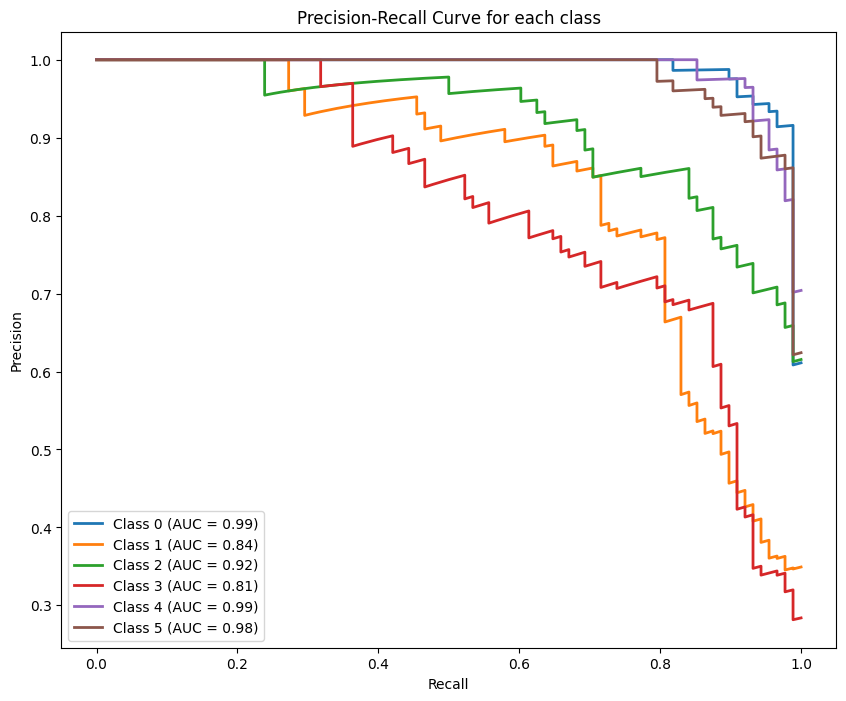

In [21]:
# Precision-Recall Curve for each class
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

n_classes = len(classes)
y_true_bin = label_binarize(test_generator.classes, classes=list(range(n_classes)))
precision = dict()
recall = dict()
auc_score = dict()

plt.figure(figsize=(10, 8))

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], Y_pred[:, i])
    auc_score[i] = auc(recall[i], precision[i])
    
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AUC = {auc_score[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for each class')
plt.legend(loc="best")
plt.show()

In [22]:
#Generate predictions for the test dataset
y_pred = model.predict(test_generator)
y_pred_labels = (y_pred>0.5).astype(int)

#Get the true labels from thee test generator
y_true = test_generator.classes

17/17 [==============================] - 55s 3s/step


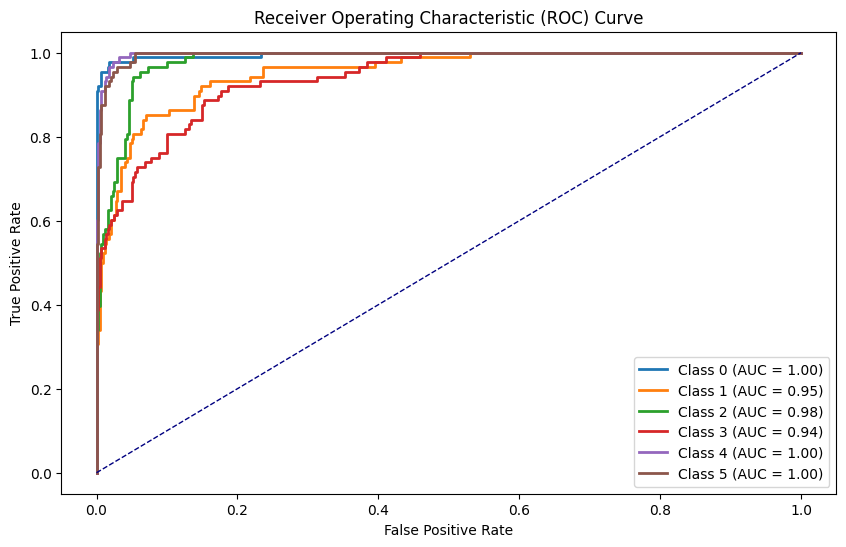

In [23]:
# Compute ROC curve
from sklearn.metrics import roc_curve, auc

#Get the true labels from thee test generator
# y_true = test_generator.classes
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

# Initialize arrays to store fpr, tpr, and auc for each class
fpr = dict()
tpr = dict()
roc_auc = dict()


# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [36]:
# Initialize the list of Sensitivity and Specificity for each class
sensitivity_list = []
specificity_list = []

# The Sensitivity and Specificity of each class were calculated
for i in range(len(cm)):
    tp = cm[i, i]  # True Positive
    fn = np.sum(cm[i, :]) - tp  # False Negative
    fp = np.sum(cm[:, i]) - tp  # False Positive
    tn = np.sum(cm) - (tp + fn + fp)  # True Negative
    
    sensitivity = tp / (tp + fn + 1e-10)  # Add a small number to avoid dividing by zero
    specificity = tn / (tn + fp + 1e-10)
    
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

# Output Sensitivity and Specificity for each category
for idx, (sen, spec) in enumerate(zip(sensitivity_list, specificity_list)):
    print(f"Class {idx} - Sensitivity: {sen}, Specificity: {spec}")

Class 0 - Sensitivity: 0.9545454545443698, Specificity: 0.9886363636361389
Class 1 - Sensitivity: 0.7727272727263946, Specificity: 0.9477272727270574
Class 2 - Sensitivity: 0.8181818181808884, Specificity: 0.9727272727270517
Class 3 - Sensitivity: 0.7840909090900181, Specificity: 0.9363636363634236
Class 4 - Sensitivity: 0.9545454545443698, Specificity: 0.9749999999997785
Class 5 - Sensitivity: 0.7954545454536415, Specificity: 0.9954545454543192


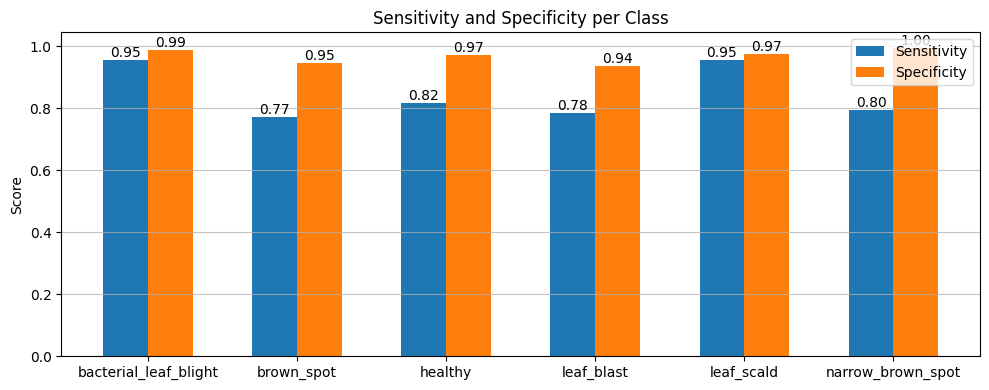

In [39]:
# 设置图形的宽度和位置  
N = len(sensitivity_list)  
ind = np.arange(N)  
width = 0.3  # 每个条形图的宽度  
  
# 绘制灵敏度的条形图  
plt.figure(figsize=(10, 4))  
sensitivity_bars = plt.bar(ind, sensitivity_list, width, label='Sensitivity')  
  
# 绘制特异度的条形图（注意：位置需要偏移以避免重叠）  
specificity_bars = plt.bar(ind + width, specificity_list, width, label='Specificity')  
   
plt.xticks(ind + width / 2, classes)  
  
# 设置x轴的标签为类别索引（如果没有具体的类标签列表）  
# plt.xticks(ind + width / 2, range(1, N + 1))  
  
# 设置y轴的标签  
plt.ylabel('Score')  
  
# 添加标题  
plt.title('Sensitivity and Specificity per Class')  
  
# 添加图例  
plt.legend()  
  
# 显示网格线  
plt.grid(axis='y', alpha=0.75)  
  
# 调整x轴和y轴的边距，以确保条形图完全可见  
plt.tight_layout()  
  
# 为每个条形添加数字标签  
def add_value_labels(bars, values):  
    for bar, value in zip(bars, values):  
        height = bar.get_height()  
        plt.text(bar.get_x() + bar.get_width() / 2, height,  
                 '{:.2f}'.format(value),  
                 ha='center', va='bottom')  
  
add_value_labels(sensitivity_bars, sensitivity_list)  
add_value_labels(specificity_bars, specificity_list)  
  
# 显示图形  
plt.show()

1/1 [==============================] - 0s 26ms/step


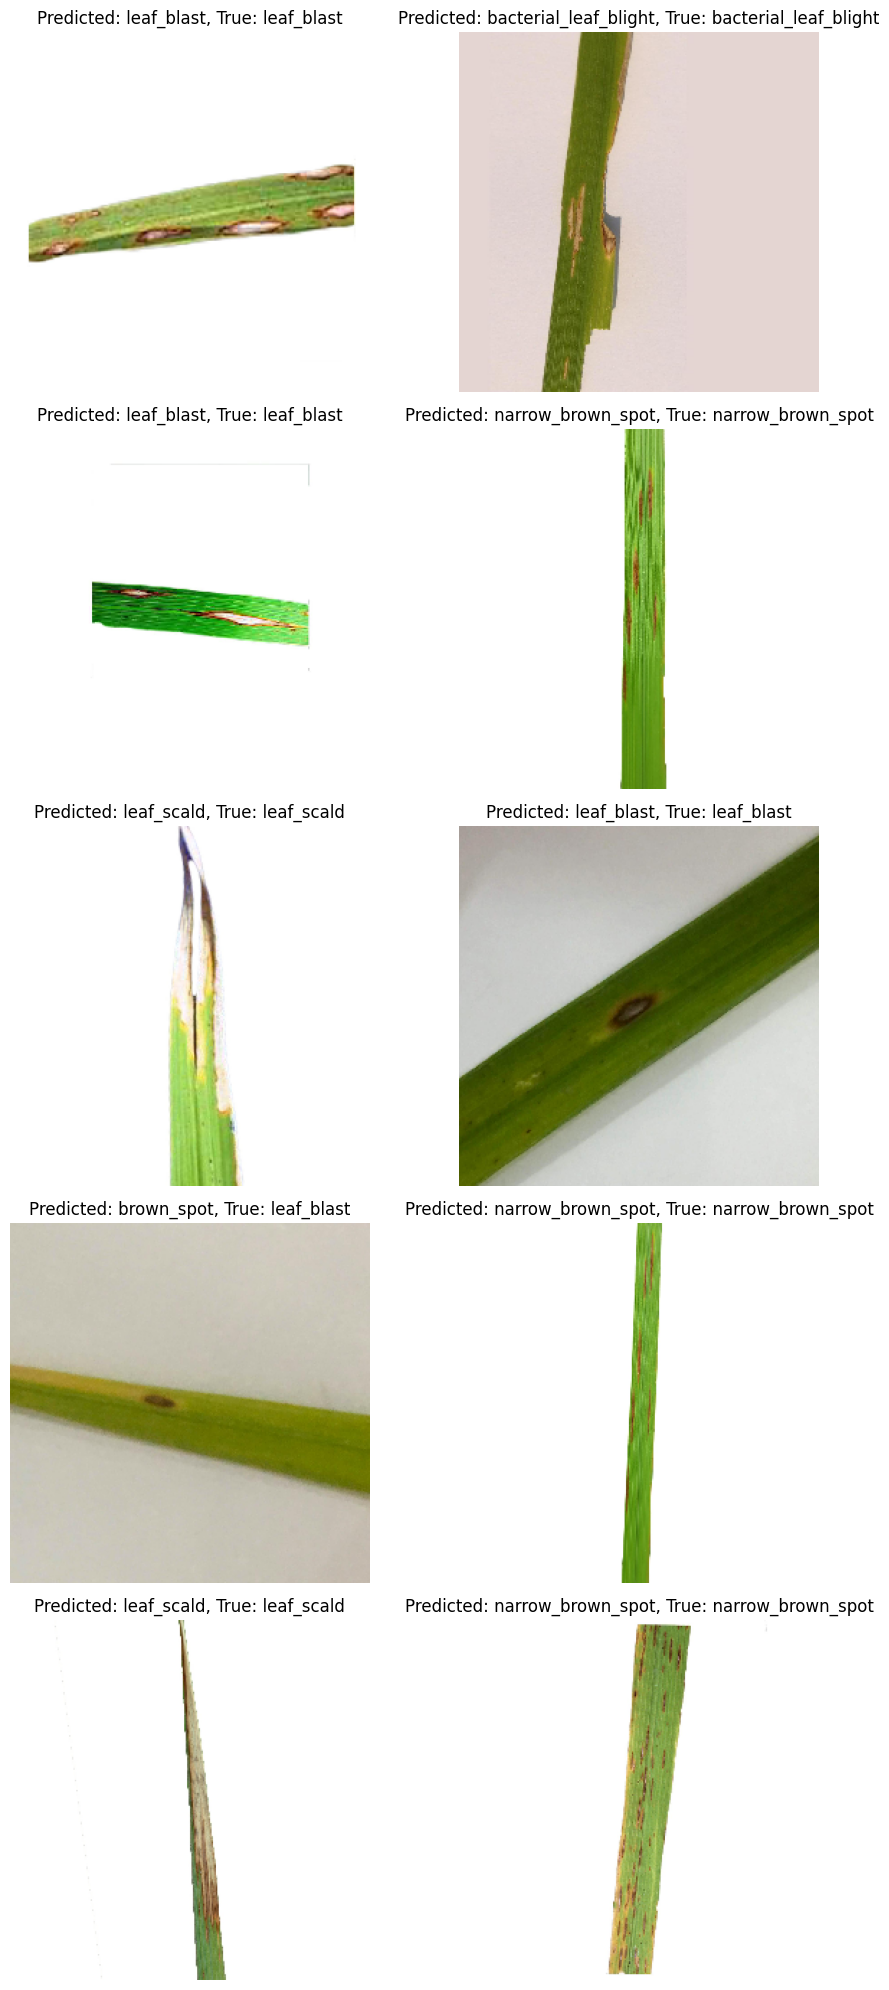

In [41]:
from tensorflow.keras.preprocessing import image as keras_image
# 10 images are randomly selected
random_indices = np.random.choice(len(test_generator.filenames), size=10, replace=False)

# Create a subplot with 2 rows and 5 columns
fig, axes = plt.subplots(5, 2, figsize=(10, 20))

for idx, ax in zip(random_indices, axes.flat):
    img_path = test_generator.filepaths[idx]

    # Load and preprocess images
    img = keras_image.load_img(img_path, target_size=(250, 250))
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    # Make model prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)

    # Get real tags
    true_label = test_generator.classes[idx]

    # Visualizations and results
    class_names = list(test_generator.class_indices.keys())

    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Predicted: {class_names[predicted_class]}, True: {class_names[true_label]}")

plt.tight_layout()
plt.show()

## Visualising Kernels

In [43]:
from tensorflow.keras import models

print("Total layers in the model : ",len(model.layers),"\n")

# We start with index 1 instead of 0, as input layer is at index 0
layers = [layer.output for layer in model.layers[1:11]]
# We now initialize a model which takes an input and outputs the above chosen layers
activations_output = models.Model(inputs=model.input, outputs=layers)
# print(layers)

layer_names = []
for layer in model.layers[1:11]: 
    layer_names.append(layer.name)
    
print("First 10 layers which we can visualize are -> ", layer_names)

Total layers in the model :  5 

First 10 layers which we can visualize are ->  ['flatten', 'dense', 'dropout', 'dense_1']


# Grad-Cam Visualization
Grad-CAM (Gradient-weighted Class Activation Mapping) is a technique used to visualize the regions of an input image that were most relevant for a neural network's prediction.  It allows you to see which regions of the image the model focused on while making its prediction.  Grad-CAM is a modification of the CAM technique that extends the latter to any model that uses a convolutional neural network (CNN) as its underlying architecture.

## Model Explainability
Model explainability is vital to convincing people that our model is working fine and its attention is at the correct place. I used two methods here, Grad-Cam and LIME.

I used almost exact code example for Grad-Cam at this link: https://keras.io/examples/vision/grad_cam/

It only shows where our pre-trained model's base is looking. On the other hand, LIME is a more intuitive tool. Let's take a sample and observe Grad-Cam and LIME outputs.

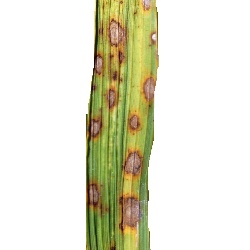

In [46]:
from IPython.display import Image, display
# The path to our target image
img_path = 'C:\\Users\\HP\\Desktop\\project\\Code\\Training all models\\RiceLeafsDisease\\training_1\\brown_spot\\brown_spot (13).jpg'
display(Image(img_path))

In [47]:
def get_img_array(img_path, size):
    # `Sİze of image 250x250
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (250, 250, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 250, 250, 3)
    array = np.expand_dims(array, axis=0)
    return array

In [48]:
images = get_img_array(img_path, im_shape)
preds = model.predict(images)
prediction = np.argmax(preds)
pct = np.max(preds)

1/1 [==============================] - 0s 25ms/step


In [49]:
if prediction == 1:
    print("ok")
else:
    print("not_ok")
    
print(pct)

ok
1.0


In [58]:
import matplotlib.cm as cm
from tensorflow.keras.preprocessing.image import array_to_img,img_to_array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    
preprocess_input = tf.keras.applications.vgg16.preprocess_input
decode_predictions = tf.keras.applications.vgg16.decode_predictions

last_conv_layer_name = "dense"#from model summary
img_size = (250,250)

# Remove last layer's softmax
model.layers[-1].activation = None

In [59]:
def display_heatmap_image(df):
    
    '''
    input : data frame 
    
    output : display 8 grad-cam images from data frame with 
    '''
    
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        img_path = df.Filepath.iloc[i]
        img_array = preprocess_input(get_img_array(img_path, size=img_size))
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        cam_path = save_and_display_gradcam(img_path, heatmap)
        ax.imshow(plt.imread(cam_path))
        ax.set_title(f"True: {df.Label.iloc[i]}\nPredicted: {df.predicted.iloc[i]}")
    plt.tight_layout()
    plt.show()

In [50]:
# System libraries
from pathlib import Path
import os.path

image_dir = Path(train_dir)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)
image_df.head(5)

,Filepath,Label
0,C:\Users\HP\Desktop\project\Code\Training all ...,bacterial_leaf_blight
1,C:\Users\HP\Desktop\project\Code\Training all ...,bacterial_leaf_blight
2,C:\Users\HP\Desktop\project\Code\Training all ...,bacterial_leaf_blight
3,C:\Users\HP\Desktop\project\Code\Training all ...,bacterial_leaf_blight
4,C:\Users\HP\Desktop\project\Code\Training all ...,bacterial_leaf_blight


In [75]:
from sklearn.model_selection import train_test_split
training_df,testing_df=train_test_split(image_df,test_size=0.1,shuffle=True,random_state=1)

print('The dimension of training data :',training_df.shape)
print('The dimension of testing data :',testing_df.shape)

The dimension of training data : (3780, 2)
The dimension of testing data : (420, 2)


In [76]:
testing_generator=ImageDataGenerator(
                                    tf.keras.applications.vgg16.preprocess_input
                                    )

In [77]:
testing_images=testing_generator.flow_from_dataframe(

    dataframe=testing_df,
    x_col='Filepath',
    y_col='Label',
    class_mode='categorical',
    target_size=(250,250),
    color_mode='rgb',
    batch_size=32,
    shuffle=False,
)

Found 420 validated image filenames belonging to 6 classes.


In [78]:
Y_pred = model.predict(testing_images)#, nb_test_samples // BATCH_SIZE, workers=1)

c:\ProgramData\Anaconda3\envs\test_env\lib\site-packages\keras\preprocessing\image.py:1863: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


14/14 [==============================] - 44s 3s/step


In [84]:
y_pred = np.argmax(Y_pred, axis=1)

In [85]:
train_generator.class_indices

{'bacterial_leaf_blight': 0,
 'brown_spot': 1,
 'healthy': 2,
 'leaf_blast': 3,
 'leaf_scald': 4,
 'narrow_brown_spot': 5}

In [87]:
labels = {v: k for k, v in train_generator.class_indices.items()} 

In [88]:
prediction = Y_pred.argmax(axis=-1)

In [89]:
prediction_labels = [labels[index] for index in prediction]

In [86]:
# labels = (train_generator.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# prediction = [labels[k] for k in prediction]

TypeError: 'numpy.int64' object is not iterable

In [91]:
y_true=testing_df['Label'].values
print(classification_report(y_true,prediction_labels, target_names=target_names, zero_division=1))

                       precision    recall  f1-score   support

bacterial_leaf_blight       0.89      0.12      0.21        67
           brown_spot       0.48      0.69      0.57        72
              healthy       1.00      0.00      0.00        78
           leaf_blast       0.80      0.19      0.31        63
           leaf_scald       1.00      0.40      0.57        55
    narrow_brown_spot       0.31      1.00      0.48        85

             accuracy                           0.42       420
            macro avg       0.75      0.40      0.36       420
         weighted avg       0.72      0.42      0.35       420



**<p style="color:#6D4318">preparing dataframe for predicted values</p>**

In [92]:
temp_df=testing_df.copy()
temp_df['predicted']=prediction_labels

temp_df.loc[temp_df['Label']==temp_df['predicted'],'Same'] = 'True'
temp_df.loc[temp_df['Label']!=temp_df['predicted'],'Same'] = 'False'
temp_df=temp_df.reset_index(drop=True)
temp_df.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_17688\88222410.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  temp_df.loc[temp_df['Label']==temp_df['predicted'],'Same'] = 'True'


,Filepath,Label,predicted,Same
0,C:\Users\HP\Desktop\project\Code\Training all ...,leaf_scald,narrow_brown_spot,False
1,C:\Users\HP\Desktop\project\Code\Training all ...,healthy,narrow_brown_spot,False
2,C:\Users\HP\Desktop\project\Code\Training all ...,bacterial_leaf_blight,narrow_brown_spot,False
3,C:\Users\HP\Desktop\project\Code\Training all ...,leaf_blast,brown_spot,False
4,C:\Users\HP\Desktop\project\Code\Training all ...,healthy,narrow_brown_spot,False


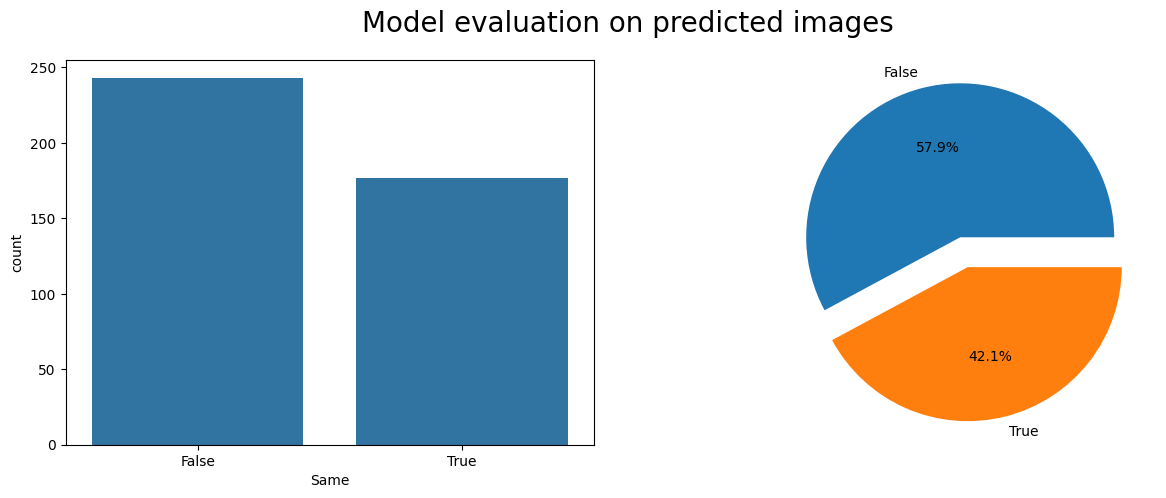

In [95]:
import seaborn as sns
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
sns.countplot(data=temp_df,x='Same')

plt.subplot(1,2,2)
plt.pie(x=temp_df['Same'].value_counts().values,labels=temp_df['Same'].value_counts().index,
        autopct='%1.1f%%',explode=[0.1,0.1])

plt.suptitle('Model evaluation on predicted images',size=20)
plt.show()

In [96]:
def display_image(temp_df):
    
    '''
    input : data frame 
    
    output : display 8 images from data frame with 
    '''
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(temp_df.Filepath.iloc[i]))
        ax.set_title(f"True: {temp_df.Label.iloc[i]}\nPredicted: {temp_df.predicted.iloc[i]}") 
    plt.tight_layout()
    plt.show()

**<p style="color:#6D4318">Displaying true predicted images</p>**

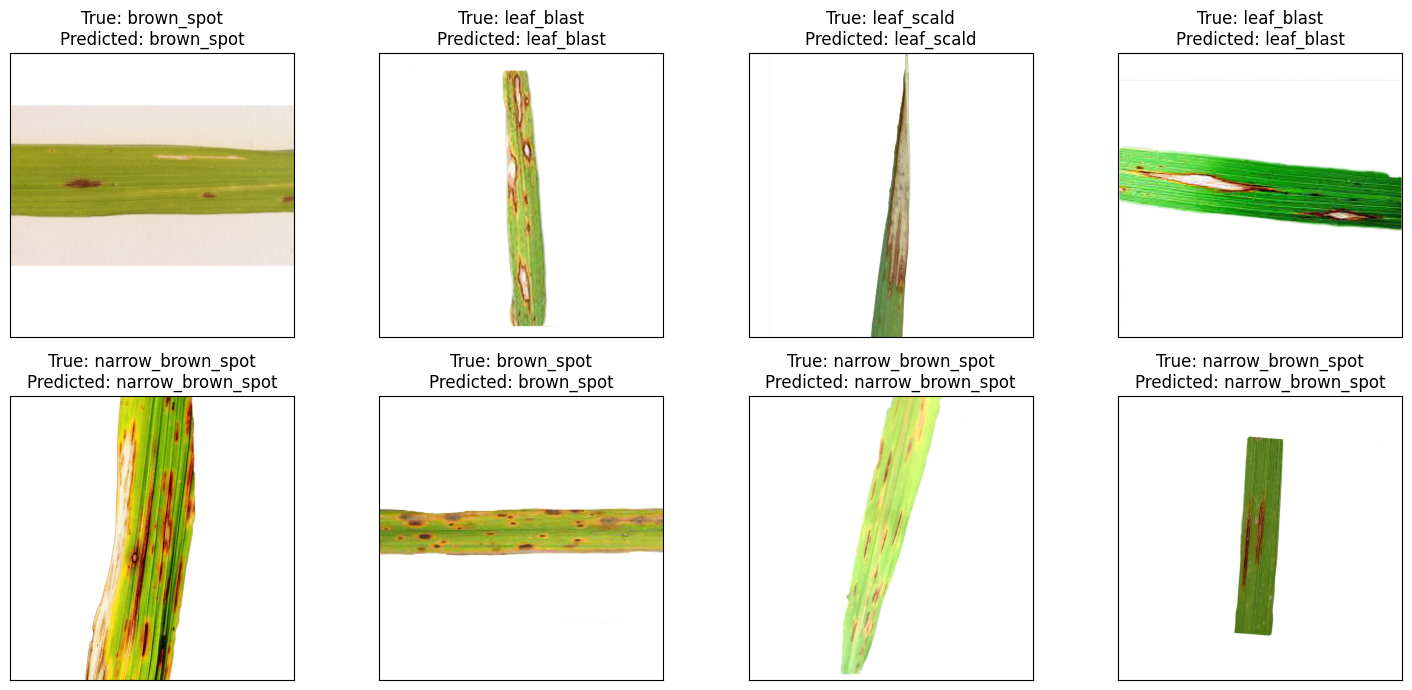

In [97]:
display_image(temp_df[temp_df['Same']=='True'])

**<p style="color:#6D4318">Displaying false predicted images</p>**

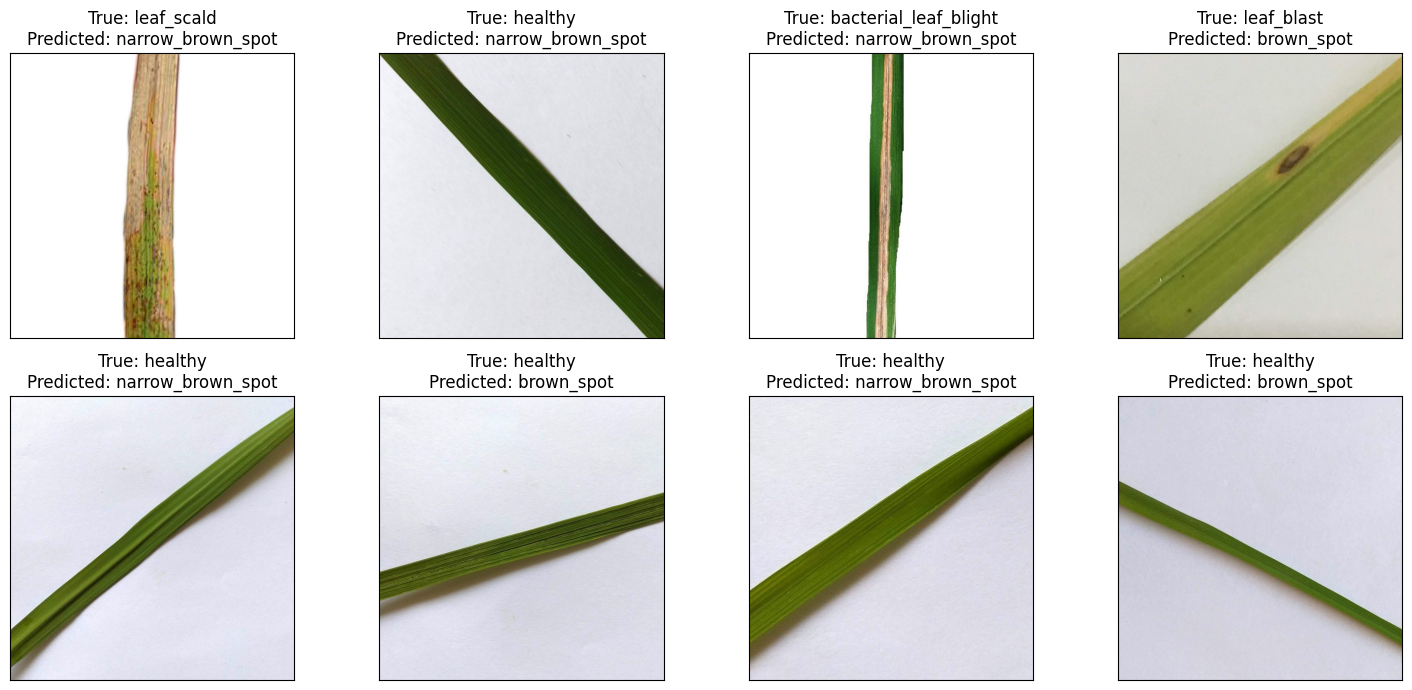

In [98]:
display_image(temp_df[temp_df['Same']=='False'])

InvalidArgumentError: {{function_node __wrapped__Mean_device_/job:localhost/replica:0/task:0/device:GPU:0}} Invalid reduction dimension (2 for input with 2 dimension(s) [Op:Mean]

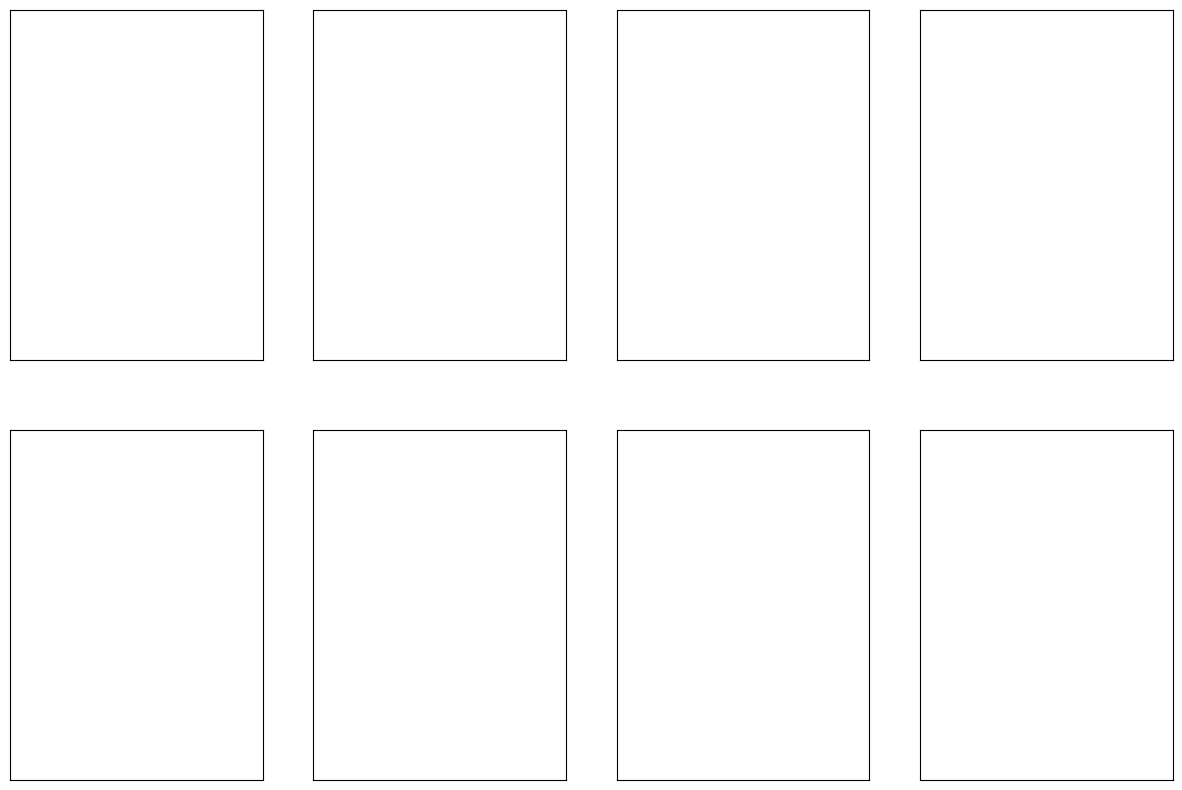

In [101]:
display_heatmap_image(temp_df[temp_df['Same']=='True'])